In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

import pickle

from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

setting environment variables properly now done.


In [4]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("double_entry_final.csv", last_day="2020-05-30", schools_unis="lol")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

In [5]:
data.mask_reopenings()

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

In [7]:
trace = pickle.load(open("final_full.pkl", "rb"))

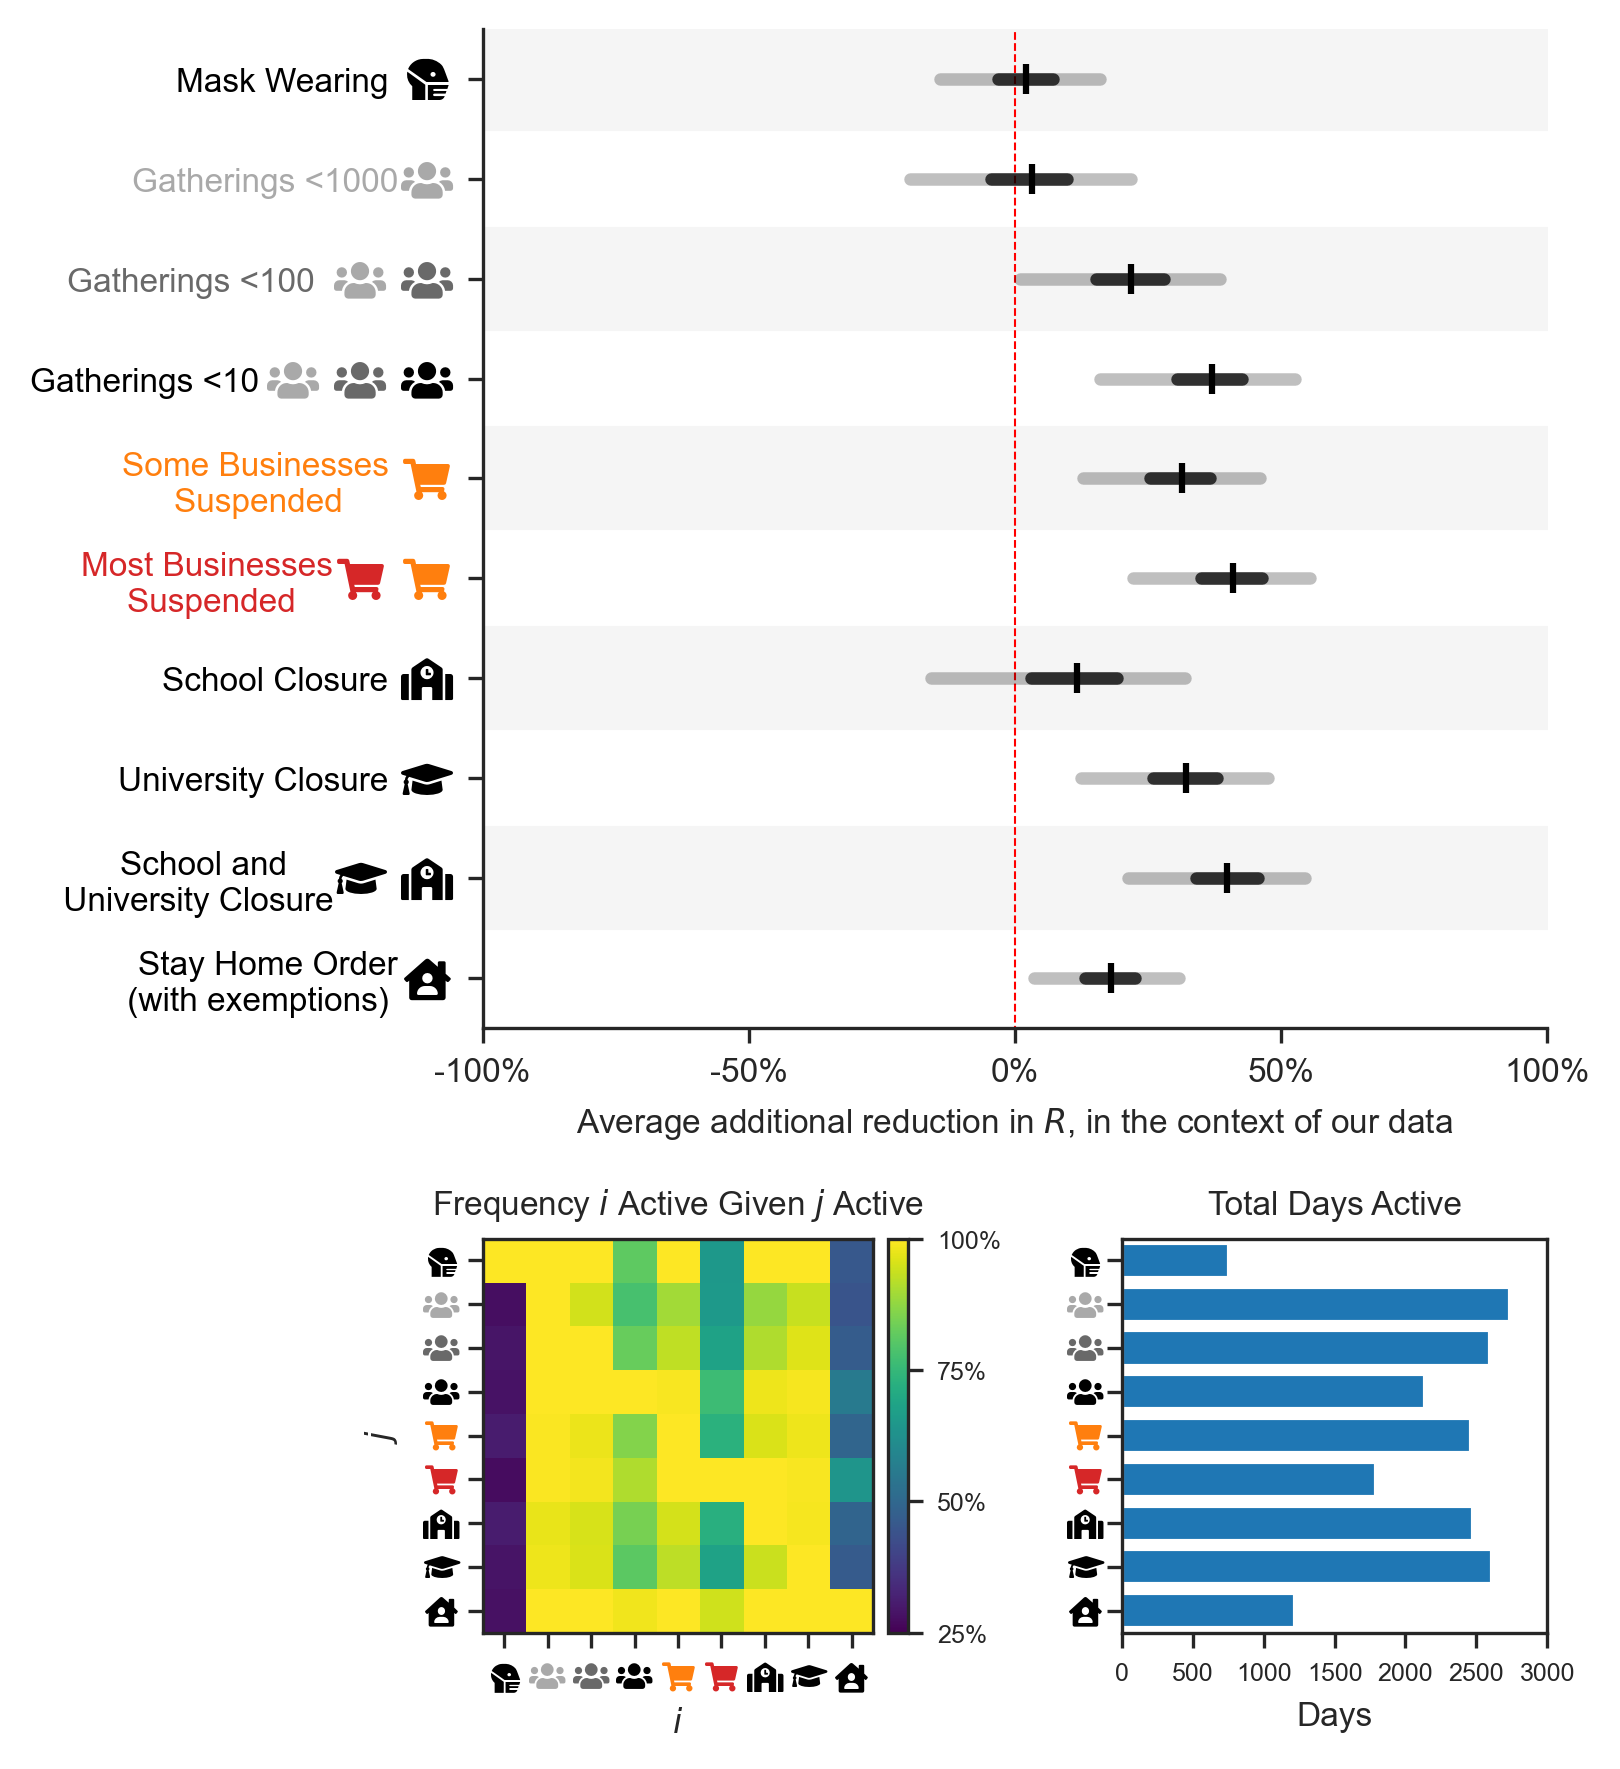

In [8]:
from matplotlib.gridspec import GridSpec

derived_features = [ #()"Healthcare Infection Control", [0]),
 ("Mask Wearing       ", [0]),
 ("Gatherings <1000      ", [1]),
 ("Gatherings <100               ", [2, 1]),
 ("Gatherings <10                     ", [3, 2, 1]),
 ("Some Businesses       \nSuspended            ", [4]),
 ("Most Businesses             \nSuspended                 ", [4, 5]),
 ("School Closure       ", [6]),
 ("University Closure       ", [7]),
 ("School and                  \n University Closure             ", [6, 7]),
 ("Stay Home Order      \n (with exemptions)       ", [8]),  
 ]

cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

features = [x for x, _ in derived_features]

res = trace.CMReduction
nS, _ = res.shape
nF = len(derived_features)

derived_res = np.zeros((nS, nF))


for f_i, (f, prodrows) in enumerate(derived_features):
    samples = np.ones(nS)
    for r in prodrows:
        samples = samples * res[:, r] 
    derived_res[:, f_i] = samples

derived_res = 100*(1-derived_res)

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq


mn, med, li, ui, lq, uq = produce_ranges(derived_res)

N_cms = mn.size

fig = plt.figure(figsize=(5.5, 6), dpi=300)

gs = GridSpec(3, 2, figure=fig)
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))

plt.plot([0, 0], [1, -(N_cms)], "--r", linewidth=0.5)
y_vals = -1 * np.arange(N_cms)

xrange = np.array([-100, 100])
for height in range(0, nF, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="whitesmoke")
    
plt.scatter(med, y_vals, marker="|", color="black", s=55)

for cm in range(N_cms):
    plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.25, linewidth=3)
    plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.75, linewidth=3)

x_min = -100
x_max = 100
plt.xlim([x_min, x_max])
xtick_vals = np.arange(-100, 150, 50)
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.ylim([-(N_cms - 0.5), 0.5])

x_r = np.abs(x_min - x_max)
for cm in range(N_cms):
    for i, val in enumerate(derived_features[cm][1]):
        if val < len(cm_plot_style):
            col = cm_plot_style[val][1]
        else:
            col = "k"
        plt.text(x_min - 10.5 - 12.5*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                     fontproperties=fp2, fontsize=10, color=col)

plt.yticks(-np.arange(N_cms), [f"{f[0]}" for f in derived_features], fontsize=8)
ax = plt.gca()

for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
    if i < len(cm_plot_style):
            col = cm_plot_style[i][1]
    else:
        col = "k"
    ticklabel.set_color(col)

plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
sns.despine()

ax1 = plt.subplot(gs.new_subplotspec((2, 0), colspan=1, rowspan=1))
data.coactivation_plot(cm_plot_style, newfig=False, skip_yticks=True,)

ax1 = plt.subplot(gs.new_subplotspec((2, 1), colspan=1, rowspan=1))
data.cumulative_days_plot(cm_plot_style, skip_yticks=True, newfig=False)

plt.tight_layout()
plt.savefig("FigureEF.pdf", bbox_inches="tight")

In [9]:
np.mean(trace.RegionR)

3.776875168735294

# Pareto Graphs

In [10]:
schools_index = data.CMs.index("School Closure")
uni_index = data.CMs.index("University Closure")

In [11]:
stk = np.hstack([data.ActiveCMs[r, :, :] for r in range(len(data.Rs))])
unique_columns, counts = np.unique(stk, return_counts = True, axis=1)
nCMs, nPkgs = unique_columns.shape
n_active = np.zeros(nPkgs)
for p in range(nPkgs):
    n_active[p] = np.sum(unique_columns[:, p])
    if unique_columns[schools_index, p] == 1 and unique_columns[uni_index, p] == 0:
        counts[p] = 0
    
    if unique_columns[schools_index, p] == 0 and unique_columns[uni_index, p] == 1:
        counts[p] = 0

In [17]:
display_together = [None, 2, 3, None, 5, None, None, None,None]

In [20]:
for d, dt in zip(data.CMs, display_together):
    print(d)
    if dt is not None:
        print(f"  with {data.CMs[dt]}")

Mask Wearing
Gatherings <1000
  with Gatherings <100
Gatherings <100
  with Gatherings <10
Gatherings <10
Some Businesses Suspended
  with Most Businesses Suspended
Most Businesses Suspended
School Closure
University Closure
Stay Home Order


In [36]:
def traverse(cm_i, pkg):
    dt = display_together[cm_i]
    
    if dt == None:
        return 0
    elif pkg[dt] == 0: 
        return 0
    elif pkg[dt] == 1:
        return 1 + traverse(dt, pkg)
    
    
def effective_active(pkg):
    n_active = 0
    for cm_i, cm in enumerate(pkg):
        if cm == 1:
            if traverse(cm_i, pkg) == 0:
                n_active += 1
    return n_active

In [31]:
def package_to_plot_info(pkg):
    n_eff = effective_active(pkg)
     
    indx = 0
    for cm_i, cm in enumerate(pkg):
        if cm == 1:
            trav = traverse(cm_i, pkg)
            

In [38]:
effective_active(unique_columns)

6

In [32]:
unique_columns = np.ones(9)

In [33]:
package_to_plot_info(unique_columns)

0
2
1
0
1
0
0
0
0


In [34]:
data.CMs

['Mask Wearing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some Businesses Suspended',
 'Most Businesses Suspended',
 'School Closure',
 'University Closure',
 'Stay Home Order']

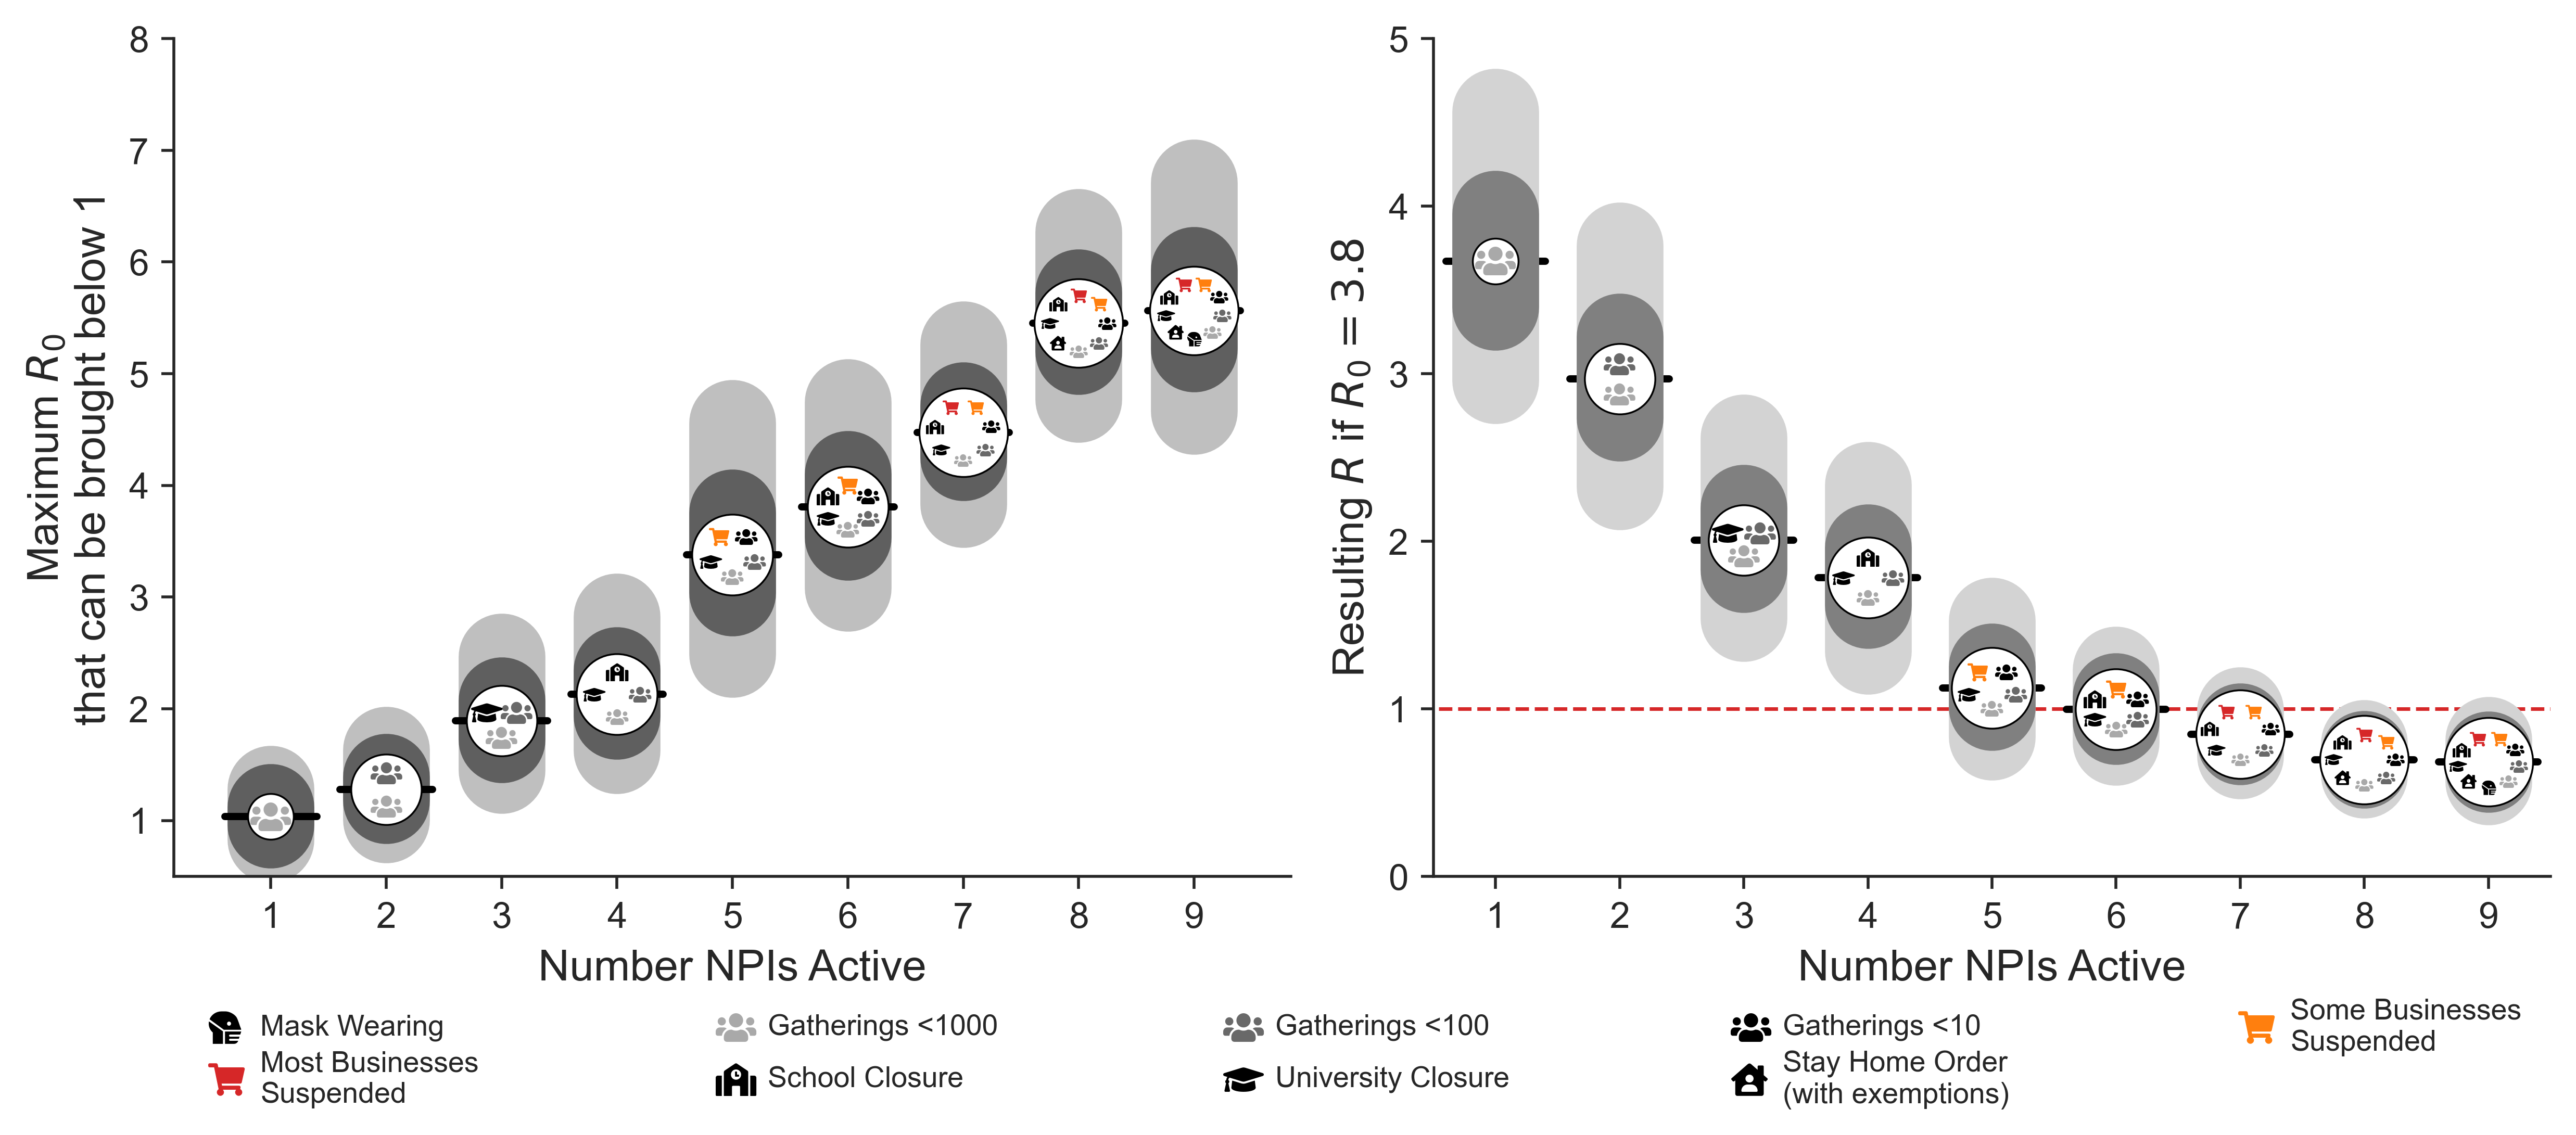

In [96]:
import seaborn as sns
sns.set_style("ticks")
colors = sns.color_palette()

fig = plt.figure(figsize=(10,4), dpi=500)

plt.subplot(121)
for p in range(nPkgs):
    pkg = unique_columns[:, p]
    count_p = counts[p]
    n_active_p = int(np.sum(pkg))
    display_mc = 1
    if np.sum(count_p < counts[n_active == n_active_p]) < display_mc:
        if n_active_p > 0:
            
            if n_active_p == 1:
                marker_size = 80*2
                text_size = 5*2-1
                r = 0.2
            elif n_active_p < 4:
                marker_size = 190*2
                text_size = 4*2-1
                r = 0.15
            elif n_active_p < 7:
                marker_size = 250*2
                text_size = 3*2-1
                r = 0.2
            else:
                marker_size = 300*2
                text_size = 5-1
                r = 0.25
            
            vals = np.ones(nS)
            for c_i in range(nCMs):
                if pkg[c_i] != 0:
                    vals = vals * trace.CMReduction[:, c_i]
            R_vals = 0.999/vals
            
            plt.scatter(n_active_p, np.median(R_vals), color="black", facecolor="white", s=marker_size, zorder=0, linewidth=0.5)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="black", linewidth=8*3, alpha=0.25)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="black", linewidth=8*3, alpha=0.5)
            plt.plot([n_active_p-0.4, n_active_p+0.4], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=-3, color="black", linewidth=2)
            
            if n_active_p > 1:
                points = [(np.cos(2*np.pi/n_active_p*x -np.pi/2)*r,np.sin((2*np.pi/n_active_p*x) -np.pi/2)*r) for x in range(0,n_active_p+1)]
                for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
                    plt.text(n_active_p + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
            else:
                nz = np.nonzero(pkg)[0].tolist()[0]
                plt.text(n_active_p , np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)
plt.ylim([0.5, 8])
plt.xlabel("Number NPIs Active", fontsize=12)
plt.ylabel("Maximum $R_0$\nthat can be brought below 1", fontsize=12)
plt.xticks(np.arange(1, 10), fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(122)
for p in range(nPkgs):
    pkg = unique_columns[:, p]
    count_p = counts[p]
    n_active_p = int(np.sum(pkg))
    if np.sum(count_p < counts[n_active == n_active_p]) < display_mc:
        if n_active_p > 0:
            
            if n_active_p == 1:
                marker_size = 80*2
                text_size = 5*2-1
                r = 0.2
            elif n_active_p < 4:
                marker_size = 190*2
                text_size = 4*2-1
                r = 0.15
            elif n_active_p < 7:
                marker_size = 250*2
                text_size = 3*2-1
                r = 0.2
            else:
                marker_size = 300*2
                text_size = 5-1
                r = 0.25
            
            vals = np.ones(nS)
            for c_i in range(nCMs):
                if pkg[c_i] != 0:
                    vals = vals * trace.CMReduction[:, c_i]
            R_vals = 3.8 * vals
            
            plt.scatter(n_active_p, np.median(R_vals), color="black", facecolor="white", s=marker_size, zorder=0, linewidth=0.5)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="lightgray", linewidth=8*3)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="gray", linewidth=8*3) 
            plt.plot([n_active_p-0.4, n_active_p+0.4], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=-3, color="black", linewidth=2)
            
            
            if n_active_p > 1:
                points = [(np.cos(2*np.pi/n_active_p*x -np.pi/2)*r,np.sin((2*np.pi/n_active_p*x) -np.pi/2)*r*0.6) for x in range(0,n_active_p+1)]
                for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
                    plt.text(n_active_p + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
            else:
                nz = np.nonzero(pkg)[0].tolist()[0]
                plt.text(n_active_p , np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)
plt.ylim([0, 5])
plt.xlim([0.5, 9.5])
plt.plot([-1, 10], [1, 1], "--", linewidth=1, color="tab:red", zorder=-5)
plt.xlabel("Number NPIs Active", fontsize=12)
plt.ylabel("Resulting $R$ if $R_0=3.8$", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.tight_layout()

cms = ["Mask Wearing", "Gatherings <1000", "Gatherings <100", "Gatherings <10", "Some Businesses\nSuspended", "Most Businesses\nSuspended", "School Closure", "University Closure", "Stay Home Order\n(with exemptions)"]
for indx, f in enumerate(data.CMs):
    fig.text(-0.015 + 0.1 + 0.195 * (indx%5), -0.05 * np.floor((indx/5)) , cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=9, va="center", ha="left", clip_on=True, zorder=1)
    fig.text(-0.015 + 0.12 + 0.195 * (indx%5), -0.00008 + -0.05 * np.floor((indx/5)), cms[indx], size=8, va="center", ha="left")

plt.savefig(f"FigurePR.pdf", bbox_inches='tight')